In [ ]:
!pip install transformers sentencepiece datasets

In [ ]:
!pip install seaborn

In [1]:
from datasets import load_dataset

from IPython.display import display
from IPython.html import widgets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import optim
from torch.nn import functional as F
from transformers import AdamW, AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm_notebook

sns.set()

/opt/conda/lib/python3.8/site-packages/IPython/html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


In [2]:
model_repo = 'Helsinki-NLP/opus-mt-en-es'
model_path = 'model/mt5_translation.pt'
max_seq_len = 20

In [3]:
tokenizer = AutoTokenizer.from_pretrained(model_repo)

In [4]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_repo)
model = model.cuda()

In [5]:
token_ids = tokenizer.encode(
    '<de> This will be translated to German! (hopefully)',
    return_tensors='pt').cuda()
print(token_ids)

model_out = model.generate(token_ids)
print(model_out)

output_text = tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(model_out[0]))
print(output_text)

tensor([[   25,  5265,   299,  1875,   143,    79,    44, 13842,    13,  3393,
            55,    22, 14447,   110, 21062,    39,     0]], device='cuda:0')
tensor([[65000,    25,  5265,   299,  1875,   107,  9154,   759, 24234,    47,
          8114,    55,    22,  1089,  4593,    39,     0]], device='cuda:0')
<pad> <de> ¡Esto será traducido al alemán! (con suerte)


In [6]:
example_input_str = '<es>This is just a test nbuig.'

input_ids = tokenizer.encode(example_input_str, return_tensors='pt')
print('Input IDs:', input_ids)

tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
print('Tokens:', tokens)

Input IDs: tensor([[  25, 5265,   98, 1875, 4650,   31,  209,    8, 2329, 1365, 3984, 4862,
            3,    0]])
Tokens: ['▁', '<', 'es', '>', 'This', '▁is', '▁just', '▁a', '▁test', '▁n', 'bu', 'ig', '.', '</s>']


In [7]:
from datasets import load_dataset, Dataset

dataset = load_dataset("opus100", "en-es")

Reusing dataset opus100 (/root/.cache/huggingface/datasets/opus100/en-es/0.0.0/a87abd612d82947c7a2c3991f71095a98f55141af7ad37516dfb31bfa3511ddc)


In [8]:
train_dataset = dataset['train']
test_dataset = dataset['test']

In [9]:
LANG_TOKEN_MAPPING = {
    'en': '<en>',
    'es': '<es>',
}

In [10]:
special_tokens_dict = {'additional_special_tokens': list(LANG_TOKEN_MAPPING.values())}
tokenizer.add_special_tokens(special_tokens_dict)
model.resize_token_embeddings(len(tokenizer))

Embedding(65003, 512)

In [11]:
token_ids = tokenizer.encode(
    example_input_str, return_tensors='pt', padding='max_length',
    truncation=True, max_length=max_seq_len)
print(token_ids)

tokens = tokenizer.convert_ids_to_tokens(token_ids[0])
print(tokens)

tensor([[65002,   143,    31,   209,     8,  2329,  1365,  3984,  4862,     3,
             0, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000]])
['<es>', '▁This', '▁is', '▁just', '▁a', '▁test', '▁n', 'bu', 'ig', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [12]:
def encode_input_str(text, target_lang, tokenizer, seq_len,
                     lang_token_map=LANG_TOKEN_MAPPING):
  target_lang_token = lang_token_map[target_lang]

  # Tokenize and add special tokens
  input_ids = tokenizer.encode(
      text = target_lang_token + text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)

  return input_ids[0]
  
def encode_target_str(text, tokenizer, seq_len,
                      lang_token_map=LANG_TOKEN_MAPPING):
  token_ids = tokenizer.encode(
      text = text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)
  
  return token_ids[0]

def format_translation_data(translations, lang_token_map,
                            tokenizer, seq_len=128):
  # Choose a random 2 languages for in i/o
  langs = list(lang_token_map.keys())
  input_lang, target_lang = np.random.choice(langs, size=2, replace=False)

  # Get the translations for the batch
  input_text = translations[input_lang]
  target_text = translations[target_lang]

  if input_text is None or target_text is None:
    return None

  input_token_ids = encode_input_str(
      input_text, target_lang, tokenizer, seq_len, lang_token_map)
  
  target_token_ids = encode_target_str(
      target_text, tokenizer, seq_len, lang_token_map)

  return input_token_ids, target_token_ids

def transform_batch(batch, lang_token_map, tokenizer):
  inputs = []
  targets = []
  for translation_set in batch['translation']:
    formatted_data = format_translation_data(
        translation_set, lang_token_map, tokenizer, max_seq_len)
    
    if formatted_data is None:
      continue
    
    input_ids, target_ids = formatted_data
    inputs.append(input_ids.unsqueeze(0))
    targets.append(target_ids.unsqueeze(0))
    
  batch_input_ids = torch.cat(inputs).cuda()
  batch_target_ids = torch.cat(targets).cuda()

  return batch_input_ids, batch_target_ids

def get_data_generator(dataset, lang_token_map, tokenizer, batch_size=32):
  dataset = dataset.shuffle()
  for i in range(0, len(dataset), batch_size):
    raw_batch = dataset[i:i+batch_size]
    yield transform_batch(raw_batch, lang_token_map, tokenizer)

In [13]:
# Testing `data_transform`
in_ids, out_ids = format_translation_data(
    train_dataset[0]['translation'], LANG_TOKEN_MAPPING, tokenizer)

print(' '.join(tokenizer.convert_ids_to_tokens(in_ids)))
print(' '.join(tokenizer.convert_ids_to_tokens(out_ids)))

# Testing data generator
data_gen = get_data_generator(train_dataset, LANG_TOKEN_MAPPING, tokenizer, 8)
data_batch = next(data_gen)
print('Input shape:', data_batch[0].shape)
print('Output shape:', data_batch[1].shape)

<es> ▁It ▁was ▁the ▁asbestos ▁in ▁here , ▁that ' s ▁what ▁did ▁it ! </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
▁Fu er on ▁los ▁asbestos ▁a quí . ▁ ¡ E so ▁es ▁lo ▁que ▁o cur ri ó ! </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 

In [14]:
n_epochs = 1
batch_size = 16
print_freq = 50
checkpoint_freq = 1000
lr = 5e-4
n_batches = int(np.ceil(len(train_dataset) / batch_size))
total_steps = n_epochs * n_batches
n_warmup_steps = int(total_steps * 0.01)

In [15]:
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer, n_warmup_steps, total_steps)

In [16]:
losses = []

In [17]:
def eval_model(model, gdataset, max_iters=8):
  test_generator = get_data_generator(gdataset, LANG_TOKEN_MAPPING,
                                      tokenizer, batch_size)
  eval_losses = []
  for i, (input_batch, label_batch) in enumerate(test_generator):
    if i >= max_iters:
      break

    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)
    eval_losses.append(model_out.loss.item())

  return np.mean(eval_losses)

In [ ]:
for epoch_idx in range(n_epochs):
  # Randomize data order
  data_generator = get_data_generator(train_dataset, LANG_TOKEN_MAPPING,
                                      tokenizer, batch_size)
                
  for batch_idx, (input_batch, label_batch) \
      in tqdm_notebook(enumerate(data_generator), total=n_batches):
    optimizer.zero_grad()

    # Forward pass
    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)

    # Calculate loss and update weights
    loss = model_out.loss
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Print training update info
    if (batch_idx + 1) % print_freq == 0:
      avg_loss = np.mean(losses[-print_freq:])
      print('Epoch: {} | Step: {} | Avg. loss: {:.3f} | lr: {}'.format(
          epoch_idx+1, batch_idx+1, avg_loss, scheduler.get_last_lr()[0]))
      
    if (batch_idx + 1) % checkpoint_freq == 0:
      test_loss = eval_model(model, test_dataset)
      print('Saving model with test loss of {:.3f}'.format(test_loss))
      torch.save(model.state_dict(), model_path)

torch.save(model.state_dict(), model_path)

<ipython-input-38-7d82fc3c8b16>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  in tqdm_notebook(enumerate(data_generator), total=n_batches):


Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/opus100/en-es/0.0.0/a87abd612d82947c7a2c3991f71095a98f55141af7ad37516dfb31bfa3511ddc/cache-7ded524bab5f1c5d.arrow


Epoch: 1 | Step: 50 | Avg. loss: 4.155 | lr: 4e-05
Epoch: 1 | Step: 100 | Avg. loss: 2.743 | lr: 8e-05
Epoch: 1 | Step: 150 | Avg. loss: 2.431 | lr: 0.00012
Epoch: 1 | Step: 200 | Avg. loss: 2.316 | lr: 0.00016
Epoch: 1 | Step: 250 | Avg. loss: 2.240 | lr: 0.0002
Epoch: 1 | Step: 300 | Avg. loss: 2.176 | lr: 0.00024
Epoch: 1 | Step: 350 | Avg. loss: 2.312 | lr: 0.00028000000000000003
Epoch: 1 | Step: 400 | Avg. loss: 2.468 | lr: 0.00032
Epoch: 1 | Step: 450 | Avg. loss: 2.365 | lr: 0.00035999999999999997
Epoch: 1 | Step: 500 | Avg. loss: 2.336 | lr: 0.0004
Epoch: 1 | Step: 550 | Avg. loss: 2.505 | lr: 0.00044
Epoch: 1 | Step: 600 | Avg. loss: 2.445 | lr: 0.00048
Epoch: 1 | Step: 650 | Avg. loss: 2.484 | lr: 0.0004997979797979798
Epoch: 1 | Step: 700 | Avg. loss: 2.505 | lr: 0.0004993939393939394
Epoch: 1 | Step: 750 | Avg. loss: 2.730 | lr: 0.000498989898989899
Epoch: 1 | Step: 800 | Avg. loss: 3.329 | lr: 0.0004985858585858586
Epoch: 1 | Step: 850 | Avg. loss: 3.297 | lr: 0.0004981818

In [18]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

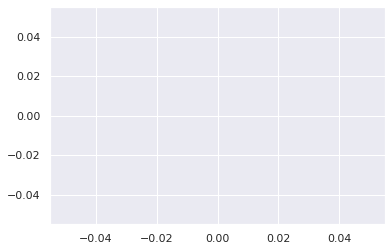

In [19]:
window_size = 50
smoothed_losses = []
for i in range(len(losses)-window_size):
  smoothed_losses.append(np.mean(losses[i:i+window_size]))

plt.plot(smoothed_losses[100:])

In [20]:
test_sentence = test_dataset[0]['translation']['en']
print('Raw input text:', test_sentence)

input_ids = encode_input_str(
    text = test_sentence,
    target_lang = 'es',
    tokenizer = tokenizer,
    seq_len = model.config.max_length,
    lang_token_map = LANG_TOKEN_MAPPING)
input_ids = input_ids.unsqueeze(0).cuda()

print('Truncated input text:', tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(input_ids[0])))

Raw input text: If your country produced ODS for this purpose, please enter the amount so produced in column 6 on Data Form 3.”
Truncated input text: <es>▁If your country▁produced▁ODS for this▁purpose,▁please▁enter the▁amount so▁produced in▁column 6 on Data▁Form 3.”<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad

In [21]:
output_tokens = model.generate(input_ids, num_beams=10, num_return_sequences=3)
# print(output_tokens)
for token_set in output_tokens:
  print(tokenizer.decode(token_set, skip_special_tokens=True))


.
..


In [24]:
output_language = 'en' #@param ["en", "de"]
#@title Slick Blue Translate
input_text = 'A surfboarder ran into a shark' #@param {type:"string"}

input_ids = encode_input_str(
    text = input_text,
    target_lang = output_language,
    tokenizer = tokenizer,
    seq_len = model.config.max_length,
    lang_token_map = LANG_TOKEN_MAPPING)
input_ids = input_ids.unsqueeze(0).cuda()

output_tokens = model.generate(input_ids, num_beams=20, length_penalty=0.2)
print(input_text + '  ->  ' + \
      tokenizer.decode(output_tokens[0], skip_special_tokens=True))

A surfboarder ran into a shark  ->  


In [26]:
from datasets import load_dataset, load_metric

metric = load_metric("bleu")

In [28]:
 compute_metrics=compute_metrics

In [31]:
compute_metrics

<function __main__.compute_metrics(eval_preds)>

In [41]:
print(f'Bleu score = {model.compute_metrics*100:.2f}')

BLeu = 36.37
